In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/winequality-white.csv", sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Prepare X and  y 

In [3]:
data.shape

(4898, 12)

In [4]:
X = data.iloc[:,:-1]
X.shape

(4898, 11)

In [5]:
y = data.iloc[:,-1]
y.shape

(4898,)

In [6]:
# convert to binary problem
y_bin = np.where(y<6, 0, 1)

## Standardized features

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
X_std = StandardScaler().fit_transform(X)

## Split the dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_bin, test_size=0.2)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3918, 11), (980, 11), (3918,), (980,))

## SVM Classifier with gaussian kernel

In [12]:
from sklearn import svm

In [13]:
classifier = svm.SVC(kernel='rbf', gamma=0.01, )

In [14]:
classifier.fit(X_train, y_train)

SVC(gamma=0.01)

In [15]:
classifier.dual_coef_

array([[-1., -1., -1., ...,  1.,  1.,  1.]])

In [16]:
classifier.intercept_

array([-0.05701822])

In [17]:
classifier.score(X_test, y_test)

0.7571428571428571

### Evaluate initial model

In [18]:
y_pred = classifier.decision_function(X_test)

In [19]:
from sklearn import metrics

In [20]:
fpr, tpr, thr = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

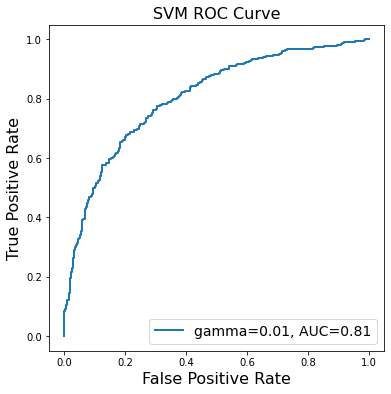

In [21]:
fig = plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, '-', lw=2, label=f"gamma=0.01, AUC={auc:.2f}")
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## SVM Classifier with Gridsearch for `C` and `gamma`

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-2, 1, 4)
param_grid = {'C': C_range, 'gamma': gamma_range}
score = 'roc_auc'

In [24]:
grid = GridSearchCV( svm.SVC(kernel='rbf'), param_grid, cv=5, scoring=score)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
             scoring='roc_auc')

### Evaluate best grid model

In [25]:
print(f"The optimal parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}")

The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.87


In [26]:
y_pred_cv = grid.decision_function(X_test)

In [27]:
fpr_cv, tpr_cv, thr_cv = metrics.roc_curve(y_test, y_pred_cv)
auc_cv = metrics.auc(fpr_cv, tpr_cv)

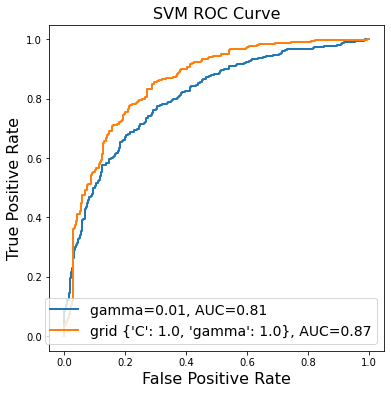

In [28]:
fig = plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, '-', lw=2, label=f"gamma=0.01, AUC={auc:.2f}")
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label=f"grid {grid.best_params_}, AUC={grid.best_score_:.2f}")
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Gram Matrix

Il peut arriver que la matrice de Gram de vos données, autrement dit la matrice K telle que  Kil=k(x(i),x(l)), est à diagonale fortement dominante, autrement dit que les nombres sur sa diagonale ont des valeurs plusieurs ordres de grandeurs plus grandes que les autres. Dans ce cas, du point de vue numérique elle ressemblera à la matrice identité (fois un grand nombre réel), et la SVM ne pourra pas bien apprendre : c'est comme si vous lui disiez que chaque point n'est semblable qu'à lui-même, et extrêmement différent des autres.

Il est donc utile d'utiliser une Matrice de Gram pour vérifier que le noyau et le gamme choisi apartent bel et bin de l'information.

In [29]:
from sklearn import metrics

In [30]:
kmatrix = metrics.pairwise.rbf_kernel(X_train, gamma=0.01)

In [31]:
kmatrix100 = kmatrix[:100, :100]

In [32]:
from matplotlib.cm import GnBu

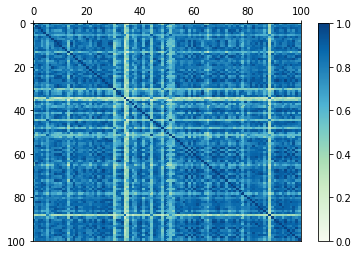

In [33]:
plt.pcolor(kmatrix100, cmap=GnBu, vmin=0, vmax=1) 
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()

### Bad Gram Matrix (too differents)

In [34]:
kmatrix = metrics.pairwise.rbf_kernel(X_train, gamma=2)

In [35]:
kmatrix100 = kmatrix[:100, :100]

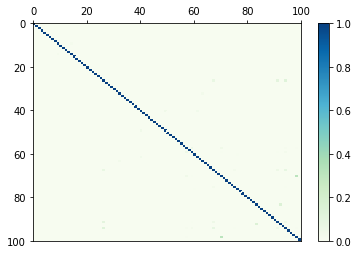

In [36]:
plt.pcolor(kmatrix100, cmap=GnBu) 
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()

### Bad Gram Matrix (too similar)

In [37]:
kmatrix = metrics.pairwise.rbf_kernel(X_train, gamma=0)

In [38]:
kmatrix100 = kmatrix[:100, :100]

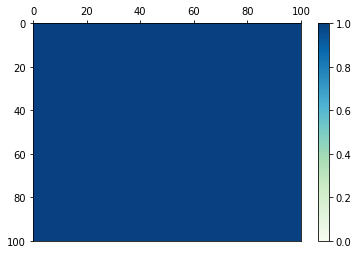

In [39]:
plt.pcolor(kmatrix100, cmap=GnBu, vmin=0, vmax=1) 
plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.show()

### Let's try the "bad" gamma setting on the ROC curve

In [40]:
bad_classifier = svm.SVC(kernel='rbf', gamma=50)

In [41]:
bad_classifier.fit(X_train, y_train)

SVC(gamma=50)

In [42]:
y_pred = bad_classifier.decision_function(X_test)

In [43]:
fpr_bad, tpr_bad, thr_bad = metrics.roc_curve(y_test, y_pred)
auc_bad = metrics.auc(fpr_bad, tpr_bad)

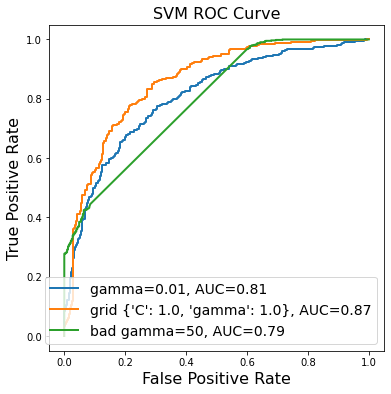

In [44]:
fig = plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, '-', lw=2, label=f"gamma=0.01, AUC={auc:.2f}")
plt.plot(fpr_cv, tpr_cv, '-', lw=2, label=f"grid {grid.best_params_}, AUC={grid.best_score_:.2f}")
plt.plot(fpr_bad, tpr_bad, '-', lw=2, label=f"bad gamma=50, AUC={auc_bad:.2f}")
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()